# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [7]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullPinTSolver, MSForwardModelSolver
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-11-07 23:17:15,200 - INFO - === Scan Summary (Continuous) ===
2025-11-07 23:17:15,202 - INFO -   Sample space (x-range): 1.000e-04 m
2025-11-07 23:17:15,206 - INFO -   Sample space (z-range): 2.000e-05 m
2025-11-07 23:17:15,209 - INFO -   Sample Pixels:          1501
2025-11-07 23:17:15,211 - INFO -   Number of scan points:  1
2025-11-07 23:17:15,215 - INFO -   Steps in z:             251
2025-11-07 23:17:15,216 - INFO -   Probe diameter:         5.000e-06 m
2025-11-07 23:17:15,219 - INFO -   Probe Pixels:          75 px


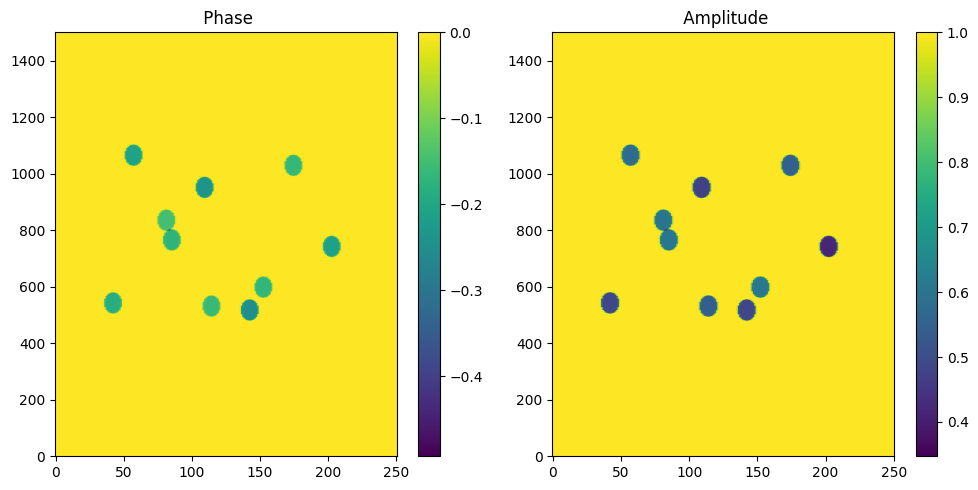

In [8]:
# --- Simulation dimension parameters ---

# --- Probe configuration ---
probe_diameter =  5e-6# meters
probe_focus = -5e-6 # focal length [m]
wavelength = 0.635e-6        # meters (0.635 μm). Wavenumber = 2pi/wavelength
probe_type = "airy_disk" #ProbeType.AIRY_DISK

# probe_angles=(np.linspace(-15,15,3))

# --- Discretization parameters ---

# Width Discretization
scan_points = 1
step_size_px = 1000
pad_factor = 1.5  # Must be >= 1.0
# Total discretization of the sample in x is: N = int(pad_factor * scan_points * step_size_px)
# If True, solve on N_effective = int((pad_factor - 1) * N)
# If False, solve on full domain N_effective = N
solve_reduced_domain = False

# Thickness Discretization
# grid points per wavelength
points_per_wavelength = 8
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 100e-6]   # meters (sample width)
zlims = [0.0, 20e-6]   # meters (sample thickness)
# if y_lims is None, assume 2D simulation

# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization, 
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    # Probe parameters
    probe_type=probe_type,
    wave_length=wavelength,
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    continuous_dimensions=(xlims, zlims),

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# Add 6 spheres of varying positions
# Base refractive index offsets
delta = 0.5 # real part (phase shift)
beta = 0.1 # complex part (absorption)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length_factor = 0.05
common_depth_factor = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length_factor=common_side_length_factor,
        centre_factor=(cx, cz), # normalized coordinates
        depth_factor=common_depth_factor,
        gaussian_blur=gaussian_blur)
    
ptycho_object.build_field()

# --- Visualize the True Object ---
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)



### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [9]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes,
                                bc_type=bc_type)

# Iterative solution
u_pwe = forward_model_pwe.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

Forward model creation and solving time: 0.70 seconds.



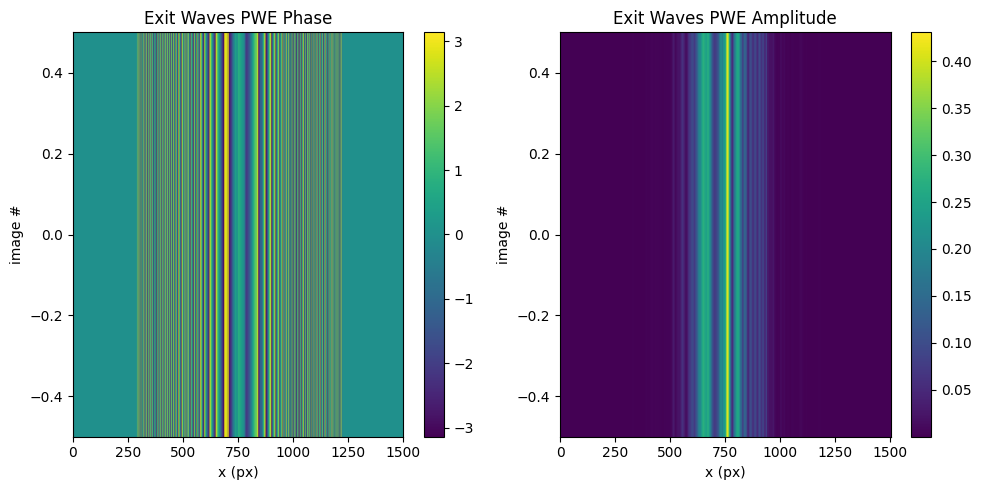

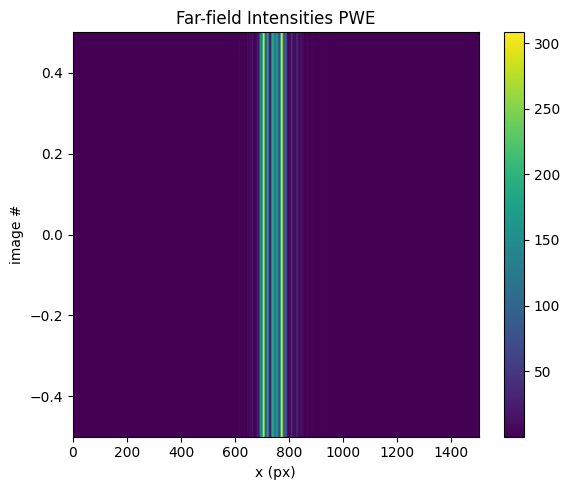

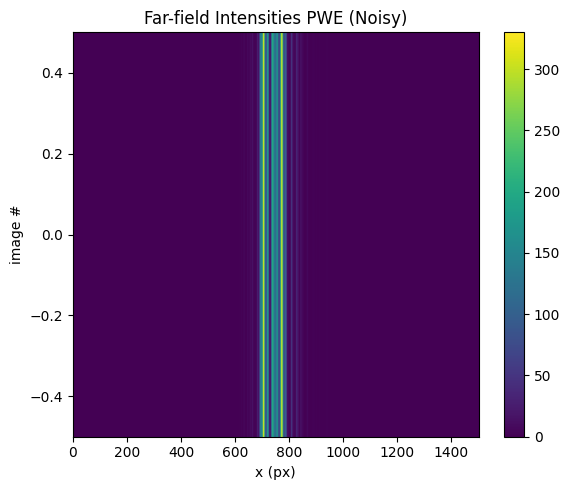

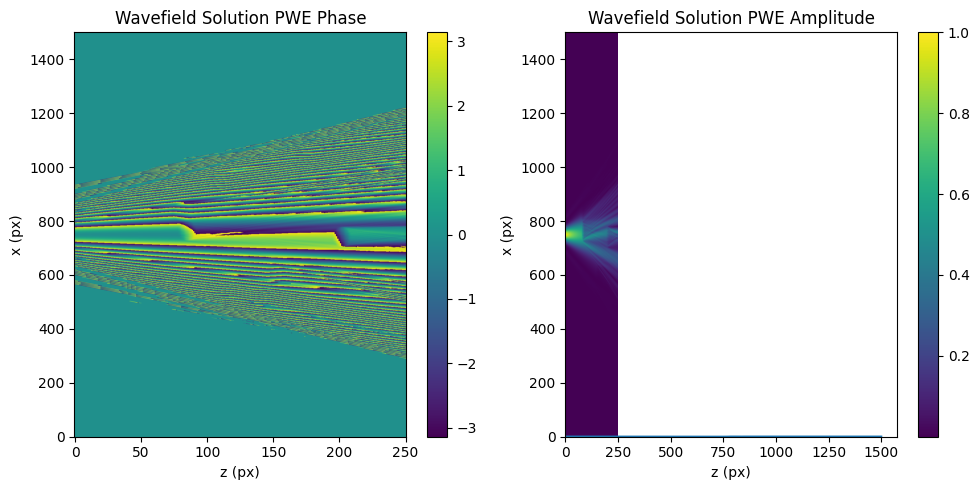

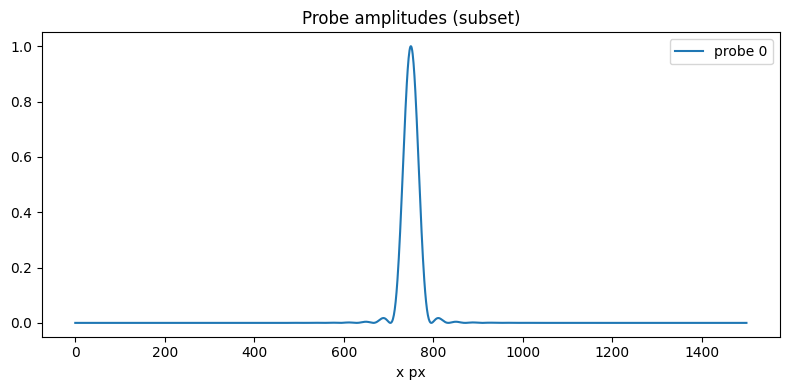

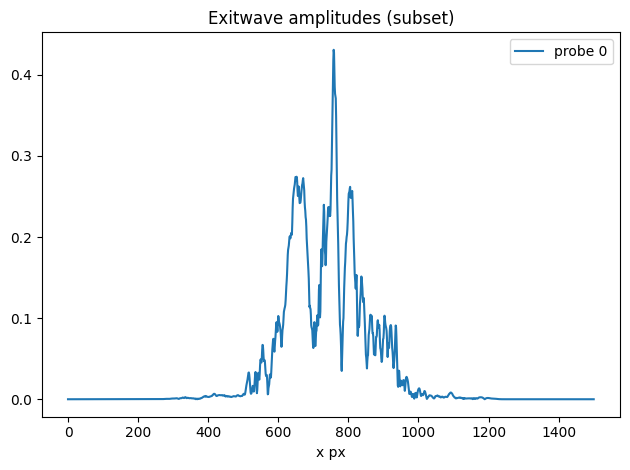

In [10]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe_noisy),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="x (px)",
                                        ylabel="image #")

# Select Centre Probe
centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (px)",
                                        ylabel="x (px)")

plt.plot(range(simulation_space.effective_nx), u_pwe[0,0,simulation_space.num_probes//2, :, simulation_space.nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = min(10,simulation_space.num_probes)#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [11]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [12]:
# Create MS Simulation Space
#dz = #wavelength / 2 # For multi-slice, keep dz larger to reduce number of slices
nz = 50#int(z_range / dz)
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()


NameError: name 'min_nx' is not defined

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 283.3673368355081
[Iter 002] Mean Loss = 272.93398193283815
[Iter 003] Mean Loss = 267.54625981063083
[Iter 004] Mean Loss = 263.92893512924036
[Iter 005] Mean Loss = 261.2195565857612
[Iter 006] Mean Loss = 259.0618215536836
[Iter 007] Mean Loss = 257.2740478575387
[Iter 008] Mean Loss = 255.7511444551497
[Iter 009] Mean Loss = 254.42692905601913
[Iter 010] Mean Loss = 253.25707509558094
Reconstruction time: 10.75 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

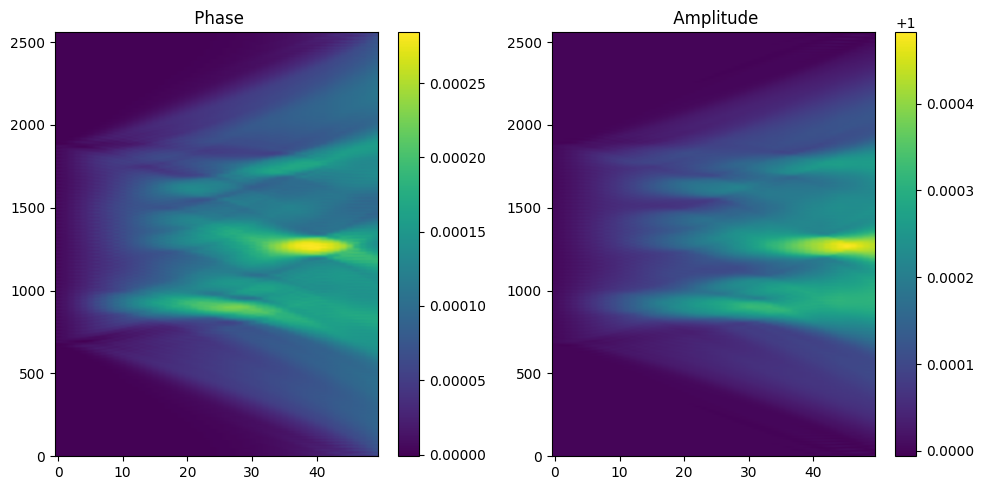

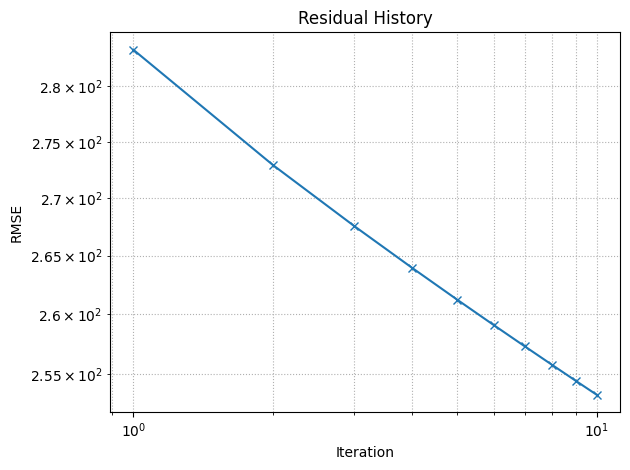

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
# recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
# time_start = time.time()
# n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
# time_end = time.time()
# print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
# simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
# simulation_space.viewer.plot_residual(residual_pwe)

: 

## Phase Retrieval

In [ ]:
# --- Reconstruction data ---
data = intensities_pwe

: 

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

: 

In [ ]:
# recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
# time_start = time.time()
# n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
# time_end = time.time()
# print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
# simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
# simulation_space.viewer.plot_residual(residual_pwe)

: 

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)

data = rng.poisson(intensities_pwe) 


Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.019148645884883415
[Iter 002] Mean Loss = 0.018361050296130273
[Iter 003] Mean Loss = 0.01797196176209421
[Iter 004] Mean Loss = 0.017718653827672976
[Iter 005] Mean Loss = 0.01753351830086237
[Iter 006] Mean Loss = 0.017389098514098866
[Iter 007] Mean Loss = 0.017271588467773435
[Iter 008] Mean Loss = 0.017173097977000302
[Iter 009] Mean Loss = 0.01708871056978873
[Iter 010] Mean Loss = 0.017015164746616445
Reconstruction time: 11.60 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

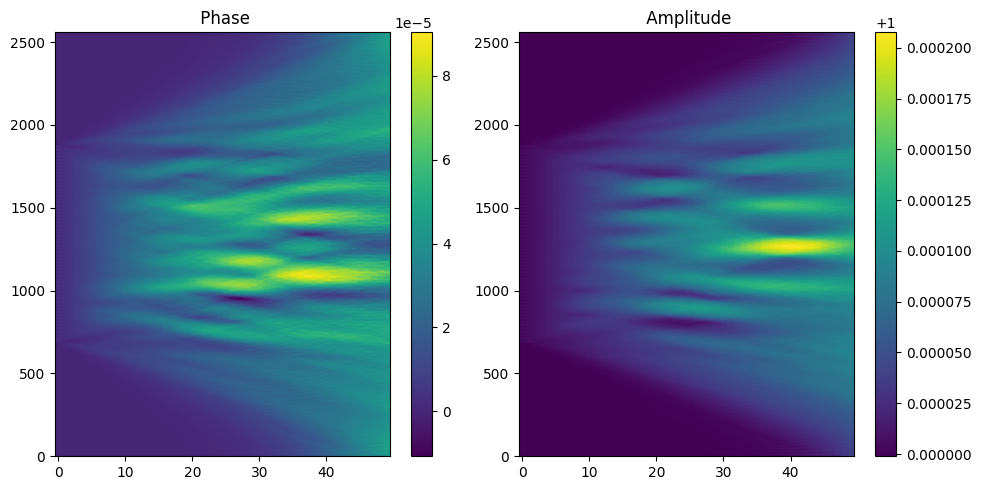

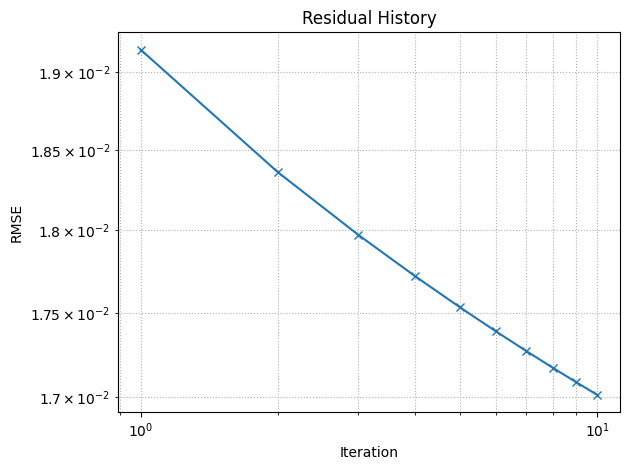

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.01094436217473302
    Iteration 1 took 17.12 seconds.
Iteration 2/10
    RMSE: 0.010734455425985738
    Iteration 2 took 18.74 seconds.
Iteration 3/10
    RMSE: 0.010533963166274012
    Iteration 3 took 16.72 seconds.
Iteration 4/10
    RMSE: 0.010336094394512649
    Iteration 4 took 18.43 seconds.
Iteration 5/10
    RMSE: 0.010140725099075898
    Iteration 5 took 18.40 seconds.
Iteration 6/10
    RMSE: 0.009947606216011654
    Iteration 6 took 18.55 seconds.
Iteration 7/10
    RMSE: 0.009756476096571558
    Iteration 7 took 17.55 seconds.
Iteration 8/10
    RMSE: 0.00956705321454435
    Iteration 8 took 18.28 seconds.
Iteration 9/10
    RMSE: 0.009379031528277178
    Iteration 9 took 16.02 seconds.
Iteration 10/10
    RMSE: 0.009192075093238161
    Iteration 10 took 19.71 seconds.
Reconstruction time: 179.53 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

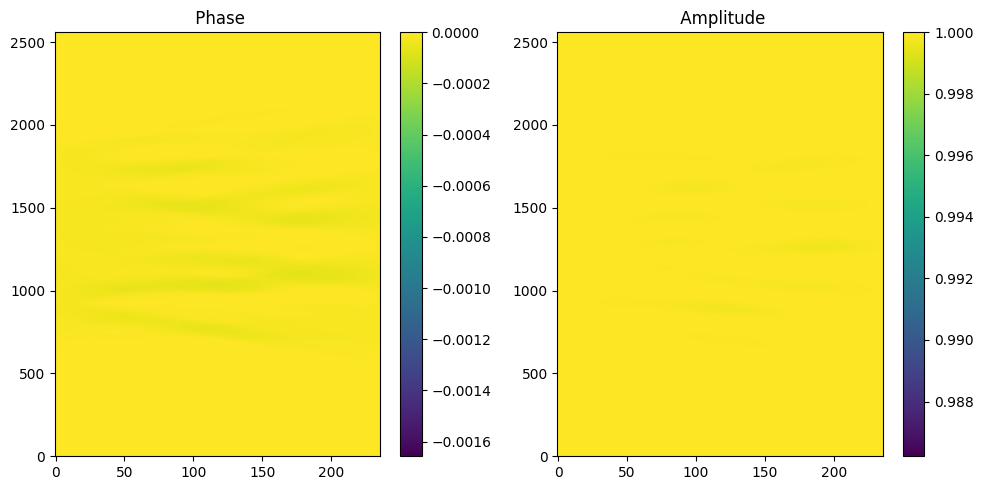

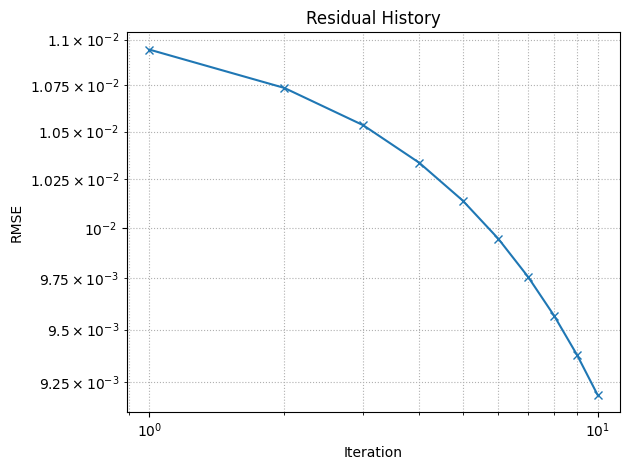

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10,lambda_amp=0.5, sigma_phase=0.05)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
colorbar_limits_left = (np.min(np.angle(ptycho_object.n_true)), np.max(np.angle(ptycho_object.n_true)))
colorbar_limits_right = (np.min(np.abs(ptycho_object.n_true)), np.max(np.abs(ptycho_object.n_true)))
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp",colorbar_limits_left=colorbar_limits_left,colorbar_limits_right=colorbar_limits_right)
simulation_space.viewer.plot_residual(residual_pwe)

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Phase'}>,
        <Axes: title={'center': ' Amplitude'}>], dtype=object))

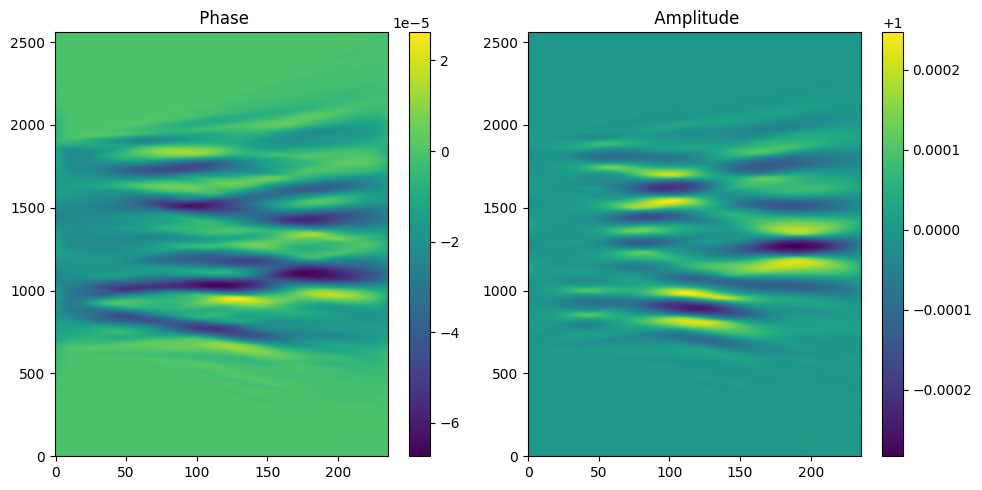

In [ ]:
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")